Using device: cuda
Processing raw data files...
Processing complete!


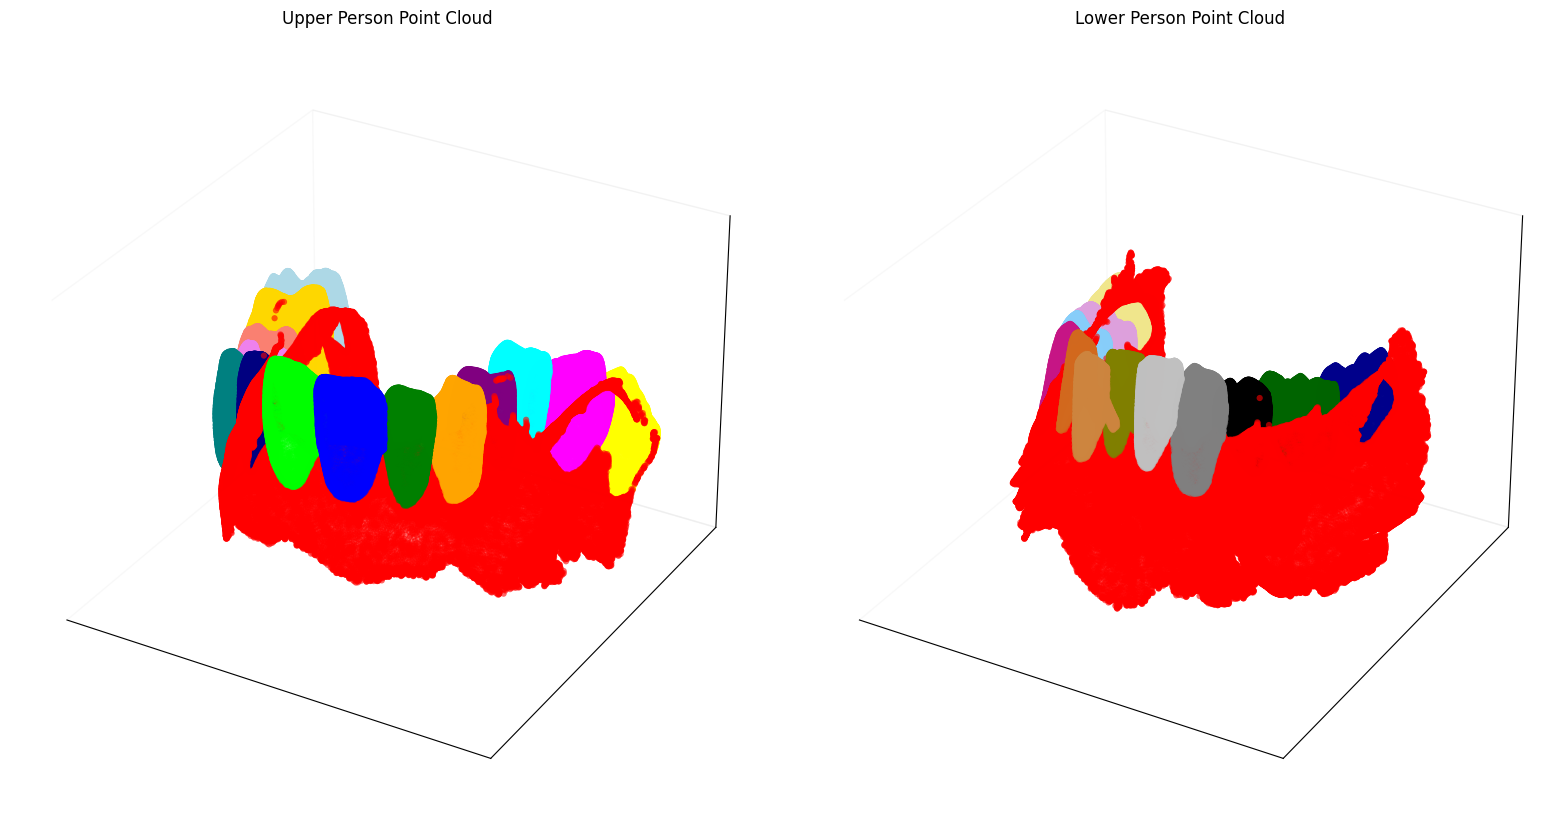

In [2]:
import os
import random
import numpy as np
import json
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
data_path = 'data_part_2'  # Current directory where upper/ and lower/ folders are located
upper_folder = os.path.join(data_path, 'upper')
lower_folder = os.path.join(data_path, 'lower')

# Create processed_data directories if they don't exist
os.makedirs('processed_data/upper', exist_ok=True)
os.makedirs('processed_data/lower', exist_ok=True)

import os

# Create output directory for visualizations
vis_dir = 'visualizations'
os.makedirs(vis_dir, exist_ok=True)

# Function to normalize point cloud
def normalize_point_cloud(points):
    centroid = np.mean(points, axis=0)
    points -= centroid
    max_distance = np.max(np.linalg.norm(points, axis=1))
    points /= max_distance
    return points

# Function to process a single file
def process_file(obj_file, json_file, output_dir):
    # Load the point cloud
    mesh = trimesh.load(obj_file)
    points = mesh.vertices
    
    # Normalize the point cloud
    points = normalize_point_cloud(points)
    
    # Save the point cloud
    np.save(os.path.join(output_dir, 'point_cloud.npy'), points)
    
    # Load JSON data
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    labels = np.array(data['labels'])
    instances = np.array(data['instances'])
    
    # Save labels and instances
    np.save(os.path.join(output_dir, 'labels.npy'), labels)
    np.save(os.path.join(output_dir, 'instances.npy'), instances)

# Function to process the entire directory
def process_directory(base_dir):
    for jaw in ['upper', 'lower']:
        jaw_dir = os.path.join(base_dir, jaw)
        if os.path.exists(jaw_dir):
            for person_dir in os.listdir(jaw_dir):
                person_path = os.path.join(jaw_dir, person_dir)
                if os.path.isdir(person_path):
                    # Get the obj and json files for this person
                    obj_file = os.path.join(person_path, f"{person_dir}_{jaw}.obj")
                    json_file = os.path.join(person_path, f"{person_dir}_{jaw}.json")
                    
                    # Check if files exist
                    if os.path.exists(obj_file) and os.path.exists(json_file):
                        output_dir = os.path.join('processed_data', jaw, person_dir)
                        os.makedirs(output_dir, exist_ok=True)
                        process_file(obj_file, json_file, output_dir)
                        print(f"Processed {person_dir} {jaw}")
                    else:
                        print(f"Missing files for {person_dir} {jaw}")

# Process the raw data first
print("Processing raw data files...")
# process_directory(data_path)
print("Processing complete!")

# Function to get a random person folder from processed data
def get_random_person(folder):
    # Check if folder exists
    processed_folder = os.path.join('processed_data', folder.split('/')[-1])
    if not os.path.exists(processed_folder):
        raise FileNotFoundError(f"Processed directory not found: {processed_folder}")
    
    persons = os.listdir(processed_folder)
    # Check if directory is empty
    if not persons:
        raise ValueError(f"No processed person data found in {processed_folder}")
    
    selected_person = random.choice(persons)
    return os.path.join(processed_folder, selected_person)

# Function to load a point cloud and its labels
def load_point_cloud_and_labels(person_path):
    point_cloud_file = os.path.join(person_path, 'point_cloud.npy')
    labels_file = os.path.join(person_path, 'labels.npy')
    
    if os.path.exists(point_cloud_file) and os.path.exists(labels_file):
        points = np.load(point_cloud_file)
        labels = np.load(labels_file)
        
        if points.ndim == 2 and points.shape[1] == 3 and labels.ndim == 1:
            points = points.astype(np.float32)
            return points, labels
        else:
            print(f"Invalid data shapes for {person_path}.")
    else:
        print(f"Files do not exist for {person_path}.")
    
    return None, None

# Function to visualize the point cloud with specific colors for labels in subplots
def visualize_point_cloud_with_labels(ax, points, labels, label_colors, title):
    for label, color in label_colors.items():
        label_mask = (labels == label)
        if np.any(label_mask):  # Only plot if there are points with this label
            ax.scatter(points[label_mask, 0], points[label_mask, 1], points[label_mask, 2],
                      color=color, label=f'Label {label}', alpha=0.6, edgecolor='none')
    
    # Remove axes and grid
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_zticks([])  # Remove z-axis ticks
    ax.xaxis.pane.fill = False  # Remove the background pane color
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)  # Disable the grid
    ax.set_title(title, pad=20)  # Adjust title padding

# Define colors for each label (customized)
label_colors = {
    0: 'red',
    11: 'blue',
    12: 'green',
    13: 'orange',
    14: 'purple',
    15: 'cyan',
    16: 'magenta',
    17: 'yellow',
    18: 'brown',
    21: 'lime',
    22: 'navy',
    23: 'teal',
    24: 'violet',
    25: 'salmon',
    26: 'gold',
    27: 'lightblue',
    28: 'coral',
    31: 'olive',
    32: 'silver',
    33: 'gray',
    34: 'black',
    35: 'darkred',
    36: 'darkgreen',
    37: 'darkblue',
    38: 'darkviolet',
    41: 'peru',
    42: 'chocolate',
    43: 'mediumvioletred',
    44: 'lightskyblue',
    45: 'lightpink',
    46: 'plum',
    47: 'khaki',
    48: 'powderblue',
}

# Now we get random persons from the processed data
try:
    # Get a random person from the upper and lower folders
    selected_upper_person = get_random_person('upper')
    selected_lower_person = get_random_person('lower')
    
    # Load the point cloud and labels for the selected upper person
    upper_points, upper_labels = load_point_cloud_and_labels(selected_upper_person)
    
    # Load the point cloud and labels for the selected lower person
    lower_points, lower_labels = load_point_cloud_and_labels(selected_lower_person)
    
    # Create subplots
    fig = plt.figure(figsize=(16, 8))
    
    # Visualize the point cloud for the selected upper person
    ax1 = fig.add_subplot(121, projection='3d')
    if upper_points is not None and upper_labels is not None:
        visualize_point_cloud_with_labels(ax1, upper_points, upper_labels, label_colors, 'Upper Person Point Cloud')
    else:
        ax1.set_title('Upper Person Point Cloud - Data not available')
    
    # Visualize the point cloud for the selected lower person
    ax2 = fig.add_subplot(122, projection='3d')
    if lower_points is not None and lower_labels is not None:
        visualize_point_cloud_with_labels(ax2, lower_points, lower_labels, label_colors, 'Lower Person Point Cloud')
    else:
        ax2.set_title('Lower Person Point Cloud - Data not available')
    
    plt.tight_layout()
    plt.savefig(os.path.join(vis_dir, 'initial_point_clouds.png'), dpi=300)
    plt.show()
except Exception as e:
    print(f"Error: {e}")
    print("If no data was processed, check that your directory structure matches the expected format:")
    print("./upper/PATIENTID/PATIENTID_upper.obj and PATIENTID_upper.json")
    print("./lower/PATIENTID/PATIENTID_lower.obj and PATIENTID_lower.json")


In [3]:
def load_data(dataset_dir):
    data = []
    # Loop over upper and lower directories
    for jaw in ['upper', 'lower']:
        jaw_dir = os.path.join(dataset_dir, jaw)
        # Loop over each person's folder in the jaw directory
        for person in os.listdir(jaw_dir):
            person_dir = os.path.join(jaw_dir, person)
            # Load the point cloud, labels, and instances
            point_cloud = np.load(os.path.join(person_dir, 'point_cloud.npy'))
            labels = np.load(os.path.join(person_dir, 'labels.npy'))
            instances = np.load(os.path.join(person_dir, 'instances.npy'))
            # Store in the data list
            data.append((point_cloud, labels, instances, jaw, person))
    return data


In [4]:
dataset_dir = 'processed_data'
data = load_data(dataset_dir)
print(f"Loaded {len(data)} samples")


Loaded 300 samples


In [5]:
def find_min_length_point_clouds(data):
    min_length = float('inf')  # Initialize to positive infinity
    for point_cloud, _, _, _, _ in data:
        length = point_cloud.shape[0]  # Number of points in the current point cloud
        min_length = min(min_length, length)  # Update min_length if current length is smaller
    return min_length

min_length = find_min_length_point_clouds(data)
print("Minimum length of point clouds:", min_length)


Minimum length of point clouds: 13034


In [6]:
def sample_points_and_labels(point_cloud, labels, min_length):
    N = point_cloud.shape[0]
    if N < min_length:
        return point_cloud, labels  # Return all points and labels if fewer than min_length
    
    indices = np.random.choice(N, min_length, replace=False)
    sampled_points = point_cloud[indices]
    sampled_labels = labels[indices]
    return sampled_points, sampled_labels

# Initialize a list to store the sampled data
sampled_data = []

# Iterate through the original dataset and sample points and labels
for point_cloud, labels, instances, jaw, person in data:
    sampled_cloud, sampled_label = sample_points_and_labels(point_cloud, labels, min_length)
    # Store as a tuple similar to the original data structure
    sampled_data.append((sampled_cloud, sampled_label, instances, jaw, person))

# Output the sampled data
for i, (cloud, label, instances, _, _) in enumerate(sampled_data):
    print(f"Sampled Point Cloud {i}: {cloud.shape}, Sampled Labels {i}: {label.shape}")


Sampled Point Cloud 0: (13034, 3), Sampled Labels 0: (13034,)
Sampled Point Cloud 1: (13034, 3), Sampled Labels 1: (13034,)
Sampled Point Cloud 2: (13034, 3), Sampled Labels 2: (13034,)
Sampled Point Cloud 3: (13034, 3), Sampled Labels 3: (13034,)
Sampled Point Cloud 4: (13034, 3), Sampled Labels 4: (13034,)
Sampled Point Cloud 5: (13034, 3), Sampled Labels 5: (13034,)
Sampled Point Cloud 6: (13034, 3), Sampled Labels 6: (13034,)
Sampled Point Cloud 7: (13034, 3), Sampled Labels 7: (13034,)
Sampled Point Cloud 8: (13034, 3), Sampled Labels 8: (13034,)
Sampled Point Cloud 9: (13034, 3), Sampled Labels 9: (13034,)
Sampled Point Cloud 10: (13034, 3), Sampled Labels 10: (13034,)
Sampled Point Cloud 11: (13034, 3), Sampled Labels 11: (13034,)
Sampled Point Cloud 12: (13034, 3), Sampled Labels 12: (13034,)
Sampled Point Cloud 13: (13034, 3), Sampled Labels 13: (13034,)
Sampled Point Cloud 14: (13034, 3), Sampled Labels 14: (13034,)
Sampled Point Cloud 15: (13034, 3), Sampled Labels 15: (1303

In [7]:
# Separate features and labels
point_clouds = np.array([item[0] for item in sampled_data])  # Sampled point clouds
labels = np.array([item[1] for item in sampled_data])  # Sampled labels


In [8]:
print(f"Point clouds shape: {point_clouds.shape}")
print(f"Labels shape: {labels.shape}")


Point clouds shape: (300, 13034, 3)
Labels shape: (300, 13034)


In [9]:
unique_labels = np.unique(np.concatenate(labels))
num_unique_labels = len(unique_labels)
print(f"Unique labels: {unique_labels}")
print(f"Number of unique labels: {num_unique_labels}")


Unique labels: [ 0 11 12 13 14 15 16 17 18 21 22 23 24 25 26 27 28 31 32 33 34 35 36 37
 38 41 42 43 44 45 46 47 48]
Number of unique labels: 33


In [10]:
# Create a mapping for your specific labels
label_to_index = {label: index for index, label in enumerate(unique_labels)}
index_to_label = {index: label for label, index in label_to_index.items()}

# Function to convert labels to consecutive indices
def convert_labels(labels):
    converted = []
    for label_array in labels:
        converted.append(np.array([label_to_index[label] for label in label_array]))
    return np.array(converted)

# Function to convert indices back to original labels
def convert_indices(indices):
    converted = []
    for index_array in indices:
        converted.append(np.array([index_to_label[index] for index in index_array]))
    return np.array(converted)


In [11]:
# PyTorch implementation of TNet
class TNet(nn.Module):
    def __init__(self, K=3):
        super(TNet, self).__init__()
        self.K = K
        self.conv1 = nn.Conv1d(K, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, K * K)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = torch.max(x, 2)[0]  # Global max pooling
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(batch_size, self.K, self.K)
        # Add identity matrix
        identity = torch.eye(self.K, dtype=x.dtype, device=x.device).unsqueeze(0).repeat(batch_size, 1, 1)
        x = x + identity
        return x

# PyTorch implementation of DentalPointNet
class DentalPointNet(nn.Module):
    def __init__(self, num_classes):
        super(DentalPointNet, self).__init__()
        self.num_classes = num_classes
        self.tnet1 = TNet(K=3)
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.tnet2 = TNet(K=64)
        self.conv3 = nn.Conv1d(64, 64, 1)
        self.conv4 = nn.Conv1d(64, 128, 1)
        self.conv5 = nn.Conv1d(128, 1024, 1)
        self.conv6 = nn.Conv1d(2048, 512, 1)  # 1024 + 1024 (concat with global features)
        self.conv7 = nn.Conv1d(512, 256, 1)
        self.conv8 = nn.Conv1d(256, 128, 1)
        self.conv9 = nn.Conv1d(128, num_classes, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)
        self.bn8 = nn.BatchNorm1d(128)
        
    def forward(self, x):
        # x shape: batch_size x num_points x 3
        batch_size, num_points, _ = x.size()
        
        # Transpose to match PyTorch Conv1d: [batch, channels, points]
        x = x.transpose(2, 1)
        
        # Input transformation
        trans1 = self.tnet1(x)
        x = torch.bmm(x.transpose(2, 1), trans1).transpose(2, 1)
        
        # MLP 1
        x = self.bn1(self.relu(self.conv1(x)))  # First conv with bn1
        x = self.bn2(self.relu(self.conv2(x)))  # Second conv with bn2
        
        # Feature transformation
        trans2 = self.tnet2(x)
        x = torch.bmm(x.transpose(2, 1), trans2).transpose(2, 1)
        
        # MLP 2
        x = self.bn3(self.relu(self.conv3(x)))  # Third conv with bn3
        x = self.bn4(self.relu(self.conv4(x)))  # Fourth conv with bn4
        x = self.bn5(self.relu(self.conv5(x)))  # Fifth conv with bn5
        
        # Global feature extraction
        global_feat = torch.max(x, 2, keepdim=True)[0]
        global_feat = global_feat.repeat(1, 1, num_points)
        
        # Concatenate local and global features
        x = torch.cat([x, global_feat], dim=1)
        
        # MLP 3
        x = self.bn6(self.relu(self.conv6(x)))  # Sixth conv with bn6
        x = self.bn7(self.relu(self.conv7(x)))  # Seventh conv with bn7
        x = self.bn8(self.relu(self.conv8(x)))  # Eighth conv with bn8
        x = self.conv9(x)  # No batch norm before final output
        
        # Transpose back to [batch, points, classes]
        x = x.transpose(2, 1)
        
        # Remove this line to fix the double softmax problem
        # x = nn.functional.softmax(x, dim=2)
        
        return x



In [12]:
# Data preparation
point_clouds_train, point_clouds_test, labels_train, labels_test = train_test_split(
    point_clouds, labels, test_size=0.2, random_state=42)

# Convert labels to consecutive indices
labels_train_converted = convert_labels(labels_train)
labels_test_converted = convert_labels(labels_test)

# Verify the conversion
print(f"Original label values: {np.unique(np.concatenate(labels_train))}")
print(f"Converted label values: {np.unique(np.concatenate(labels_train_converted))}")
print(f"Number of unique classes: {len(np.unique(np.concatenate(labels_train_converted)))}")


Original label values: [ 0 11 12 13 14 15 16 17 18 21 22 23 24 25 26 27 28 31 32 33 34 35 36 37
 38 41 42 43 44 45 46 47 48]
Converted label values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Number of unique classes: 33


In [13]:
# PyTorch Dataset
class PointCloudDataset(Dataset):
    def __init__(self, point_clouds, labels):
        self.point_clouds = point_clouds
        self.labels = labels
        
    def __len__(self):
        return len(self.point_clouds)
    
    def __getitem__(self, idx):
        point_cloud = torch.from_numpy(self.point_clouds[idx].astype(np.float32))
        label = torch.from_numpy(self.labels[idx].astype(np.int64))
        return point_cloud, label


# Create DataLoaders
train_dataset = PointCloudDataset(point_clouds_train, labels_train_converted)
val_split = int(0.2 * len(train_dataset))
train_split = len(train_dataset) - val_split
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_split, val_split])

batch_size = 4
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size)
test_dataset = PointCloudDataset(point_clouds_test, labels_test_converted)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [14]:
# Create and compile the model
model = DentalPointNet(num_classes=num_unique_labels).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, min_lr=1e-5)


In [15]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=200):
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    # Save best model
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for points, target in train_loader:
            points, target = points.to(device), target.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(points)
            
            # Reshape for loss calculation
            outputs_reshaped = outputs.reshape(-1, num_unique_labels)
            target_reshaped = target.reshape(-1)
            
            # Compute loss
            loss = criterion(outputs_reshaped, target_reshaped)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * points.size(0)
            _, predicted = torch.max(outputs, 2)
            total += target.numel()
            correct += (predicted == target).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for points, target in val_loader:
                points, target = points.to(device), target.to(device)
                
                # Forward pass
                outputs = model(points)
                
                # Reshape for loss calculation
                outputs_reshaped = outputs.reshape(-1, num_unique_labels)
                target_reshaped = target.reshape(-1)
                
                # Compute loss
                loss = criterion(outputs_reshaped, target_reshaped)
                
                # Statistics
                val_loss += loss.item() * points.size(0)
                _, predicted = torch.max(outputs, 2)
                val_total += target.numel()
                val_correct += (predicted == target).sum().item()
        
        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        
        # Update scheduler
        scheduler.step(val_epoch_loss)
        
        # Save history
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_acc)
        history['val_loss'].append(val_epoch_loss)
        history['val_accuracy'].append(val_epoch_acc)
        
        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | '
              f'Train Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_epoch_loss:.4f} | '
              f'Val Acc: {val_epoch_acc:.4f}')
        
        # Save model if it's the best so far
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), 'best_dental_pointnet_model.pth')
    
    return history


In [ ]:
# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)


In [16]:
# Save the final model
torch.save(model.state_dict(), 'dental_pointnet_model.pth')
print("Model training and evaluation completed. Model saved in PyTorch format.")


Model training and evaluation completed. Model saved in PyTorch format.


In [18]:
# Evaluate the model on test data
def evaluate_model_in_batches(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for points, target in test_loader:
            points, target = points.to(device), target.to(device)
            
            # Forward pass
            outputs = model(points)
            
            # Reshape for loss calculation
            outputs_reshaped = outputs.reshape(-1, num_unique_labels)
            target_reshaped = target.reshape(-1)
            
            # Compute loss
            loss = criterion(outputs_reshaped, target_reshaped)
            
            # Statistics
            test_loss += loss.item() * points.size(0)
            _, predicted = torch.max(outputs, 2)
            total += target.numel()
            correct += (predicted == target).sum().item()
    
    average_loss = test_loss / len(test_loader.dataset)
    average_accuracy = correct / total
    
    return average_loss, average_accuracy


In [19]:
# Load the best model
model.load_state_dict(torch.load('best_dental_pointnet_model.pth'))
average_loss, average_accuracy = evaluate_model_in_batches(model, test_loader, criterion)
print(f"Average Loss: {average_loss}")
print(f"Average Accuracy: {average_accuracy}")


C:\Users\plane\AppData\Local\Temp\ipykernel_3012\279136375.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_dental_pointnet_model.p

Average Loss: 0.6963729361693064
Average Accuracy: 0.7688340749833769


In [ ]:
# Visualize training results
plt.figure(figsize=(12, 5))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(vis_dir, 'training_validation_metrics.png'), dpi=300)
plt.show()


In [21]:
# Visualize predictions on a test sample
def visualize_predictions(model, device, point_cloud_sample, true_labels_sample):
    # Add .float() to convert from double to float32
    point_cloud_tensor = torch.from_numpy(point_cloud_sample).unsqueeze(0).float().to(device)
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        predictions = model(point_cloud_tensor)
        predicted_labels = torch.argmax(predictions, dim=2)[0].cpu().numpy()
    
    # Convert indices back to original labels
    predicted_labels = np.array([index_to_label[label] for label in predicted_labels])
    
    # Map labels to colors
    true_colors = np.array([label_colors[label] if label in label_colors else 'gray' for label in true_labels_sample])
    predicted_colors = np.array([label_colors[label] if label in label_colors else 'gray' for label in predicted_labels])
    
    # Create a figure for true vs predicted labels
    fig = plt.figure(figsize=(16, 8))
    
    # True labels plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(point_cloud_sample[:, 0], point_cloud_sample[:, 1], point_cloud_sample[:, 2],
                c=true_colors, marker='o')
    ax1.set_title('True Segmentation')
    
    # Predicted labels plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(point_cloud_sample[:, 0], point_cloud_sample[:, 1], point_cloud_sample[:, 2],
                c=predicted_colors, marker='o')
    ax2.set_title('Predicted Segmentation')
    
    plt.tight_layout()
    plt.savefig(os.path.join(vis_dir, 'true_vs_predicted_segmentation.png'), dpi=300)
    plt.show()
    fig.canvas.mpl_connect('key_press_event', lambda event: plt.close() if event.key == 'escape' else None)



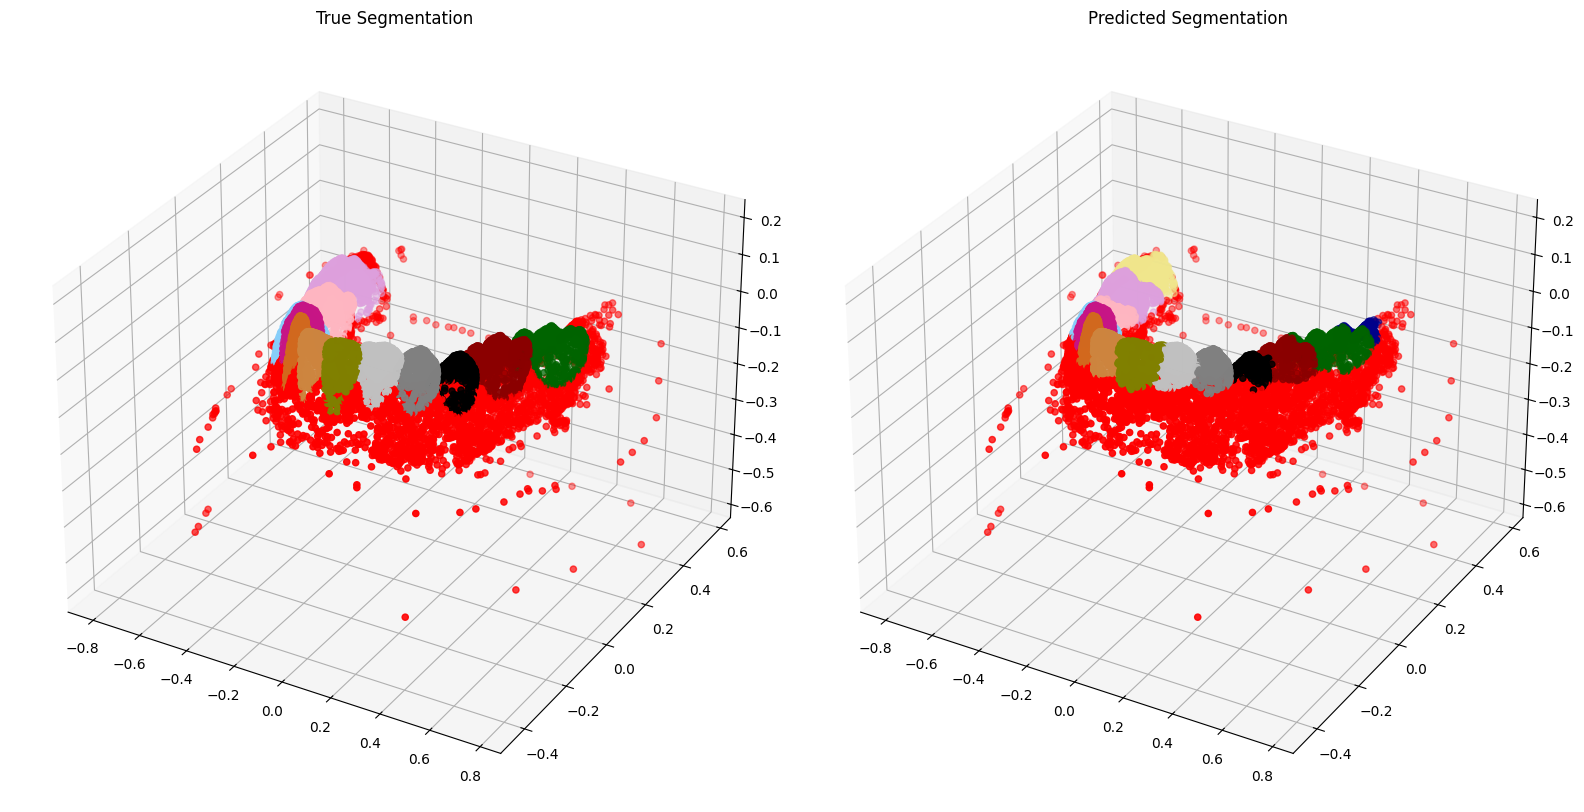

In [24]:
# Get a sample from the test set
sample_idx = 2
point_cloud_sample = point_clouds_test[sample_idx].astype(np.float32)
true_labels_sample = labels_test[sample_idx]
# Visualize predictions
visualize_predictions(model, device, point_cloud_sample, true_labels_sample)
